In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import toml
import glob
import os
pd.options.mode.chained_assignment = None  # default='warn'
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from presentation.pipelines.steps.load_data import build_loader
from presentation.pipelines.steps.model_design import load_pt_model 

from src.utils import get_metrics

%load_ext autoreload
%autoreload 2

2024-07-09 20:36:38.034623: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def get_info_from_path(path, clf=False):
    factors = curr.split('/')
    info = {
        'ds_name': factors[6],
        'fold_n': int(factors[7].split('_')[-1]),
        'spc': int(factors[8].split('_')[-1]),
        'factors': factors[9] if clf else None
    }
    return info
def get_label(row, features_spec):
    label = []
    for f in features_spec:
        label.append(str(row[f]))
    label = '_'.join(label)
    return label

zero_alcock = {'20':0.27, '100':0.59}
zero_atlas = {'20':0.54, '100':0.56}

In [4]:
paths = glob.glob(os.path.join('./presentation/results/', '*', '*'))
paths

['./presentation/results/maogat/2024-07-05_14-22-52',
 './presentation/results/maogat/2024-06-02_04-10-22',
 './presentation/results/maogat/2024-06-02_04-19-29',
 './presentation/results/maogat/2024-06-02_04-18-39',
 './presentation/results/paper/2024-07-09_02-27-29',
 './presentation/results/classic/2024-07-02_22-29-44',
 './presentation/results/classic/2024-06-24_17-31-29',
 './presentation/results/classic/2024-07-02_22-31-31']

## Pretraining

In [5]:
config_list = []
for curr_path in paths:
    
    try:
        rmse_df = get_metrics(os.path.join(curr_path, 
                                           'pretraining', 
                                           'tensorboard', 
                                           'validation'), 
                              metric_name='epoch_rmse')

        rsquare_df = get_metrics(os.path.join(curr_path, 
                                           'pretraining', 
                                           'tensorboard', 
                                           'validation'), 
                              metric_name='epoch_r_square')
        df = rmse_df[rmse_df['value'] == rmse_df['value'].min()]
    
        df_r2 = rsquare_df[rsquare_df.step == df.step.values[0]]
        
        with open(os.path.join(curr_path, 'pretraining', 'config.toml'), 'r') as handle:
            config = toml.load(handle)
            
        config['val_rmse'] = df.value.values[0]
        config['val_r2'] = df_r2.value.values[0]
            
    except Exception as e:
        rmse_df = get_metrics(os.path.join(curr_path, 
                                           'pretraining', 
                                           'tensorboard', 
                                           'validation'), 
                              metric_name='mse')
        
        model, config = load_pt_model(os.path.join(curr_path, 'pretraining'))
        
        
        
        data_loader = build_loader(config['data'], 
                                   config, 
                                   batch_size=2000, 
                                   normalize='zero-mean', 
                                   sampling=False,
                                   repeat=1,
                                   old_version=False)
        model.compile(optimizer='adam')
        loss, r2, rmse = model.evaluate(data_loader['validation'].take(2))

        config['val_rmse'] = rmse
        config['val_r2'] = r2
    config_list.append(config)

[INFO] Zero architecture loaded
[INFO] Using masked-att with alpha = 1.00


2024-07-09 20:36:42.228010: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-09 20:36:42.231219: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-09 20:36:42.231633: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-09 20:36:42.232887: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

[INFO] Using masked-att with alpha = 1.00
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2024-07-09 20:36:43,623 - WARNING - From /usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/pyct/static_analysis/liveness.py:83: Analyzer.lamba_check (from tensorflow.python.autograph.pyct.static_analysis.liveness) is deprecated and will be removed after 2023-09-23.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


[INFO] Using PE with c: 2.0
[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens


2024-07-09 20:36:44,453 - WARNING - Inconsistent references when loading the checkpoint into this object graph. For example, in the saved checkpoint object, `model.layer.weight` and `model.layer_copy.weight` reference the same variable, while in the current object these are two different variables. The referenced variables are:(<src.models.astromer_0.Encoder object at 0x7ff658b8ab20> and <src.models.astromer_0.RegLayer object at 0x7ff658b8ae20>).


[INFO] Probed: 0.50 Random: 0.20 Same: 0.20
[INFO] Repeating dataset x1 times
[INFO] Normalization:  zero-mean
[INFO] Loading PT task: Masking
[INFO] Zero
[INFO] Probed: 0.50 Random: 0.20 Same: 0.20
[INFO] Repeating dataset x1 times
[INFO] Normalization:  zero-mean
[INFO] Loading PT task: Masking
[INFO] Zero


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['mask_out'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


[INFO] Using PE with c: 2.0
[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens


2024-07-09 20:36:59.204390: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3/3 [==============================] - 4s 343ms/step - loss: 0.1538 - r_square: 0.7983 - rmse: 0.1538


In [6]:
summary = pd.DataFrame(config_list)
summary = summary[['exp_name', 'lr', 'mask_format', 'temperature', 'probed', 'val_rmse', 'val_r2']]
summary

,exp_name,lr,mask_format,temperature,probed,val_rmse,val_r2
0,maogat,0.00001,K,0.8,0.3,0.088669926,0.43396366
1,maogat,0.00001,K,0.0,0.3,0.087313384,0.44796115
2,maogat,0.00001,logits,0.0,0.3,0.09282409,0.35887766
3,maogat,0.00001,K,0.5,0.3,0.089466944,0.44134116
4,zero,0.00100,QK,0.0,0.5,0.153142,0.797852
5,classic,0.00001,K,0.0,0.3,0.2916558,0.10024351
6,classic,0.00001,K,0.0,0.5,0.28978977,0.24730015
7,classic,0.00001,K,0.0,0.1,0.2557465,0.19493264


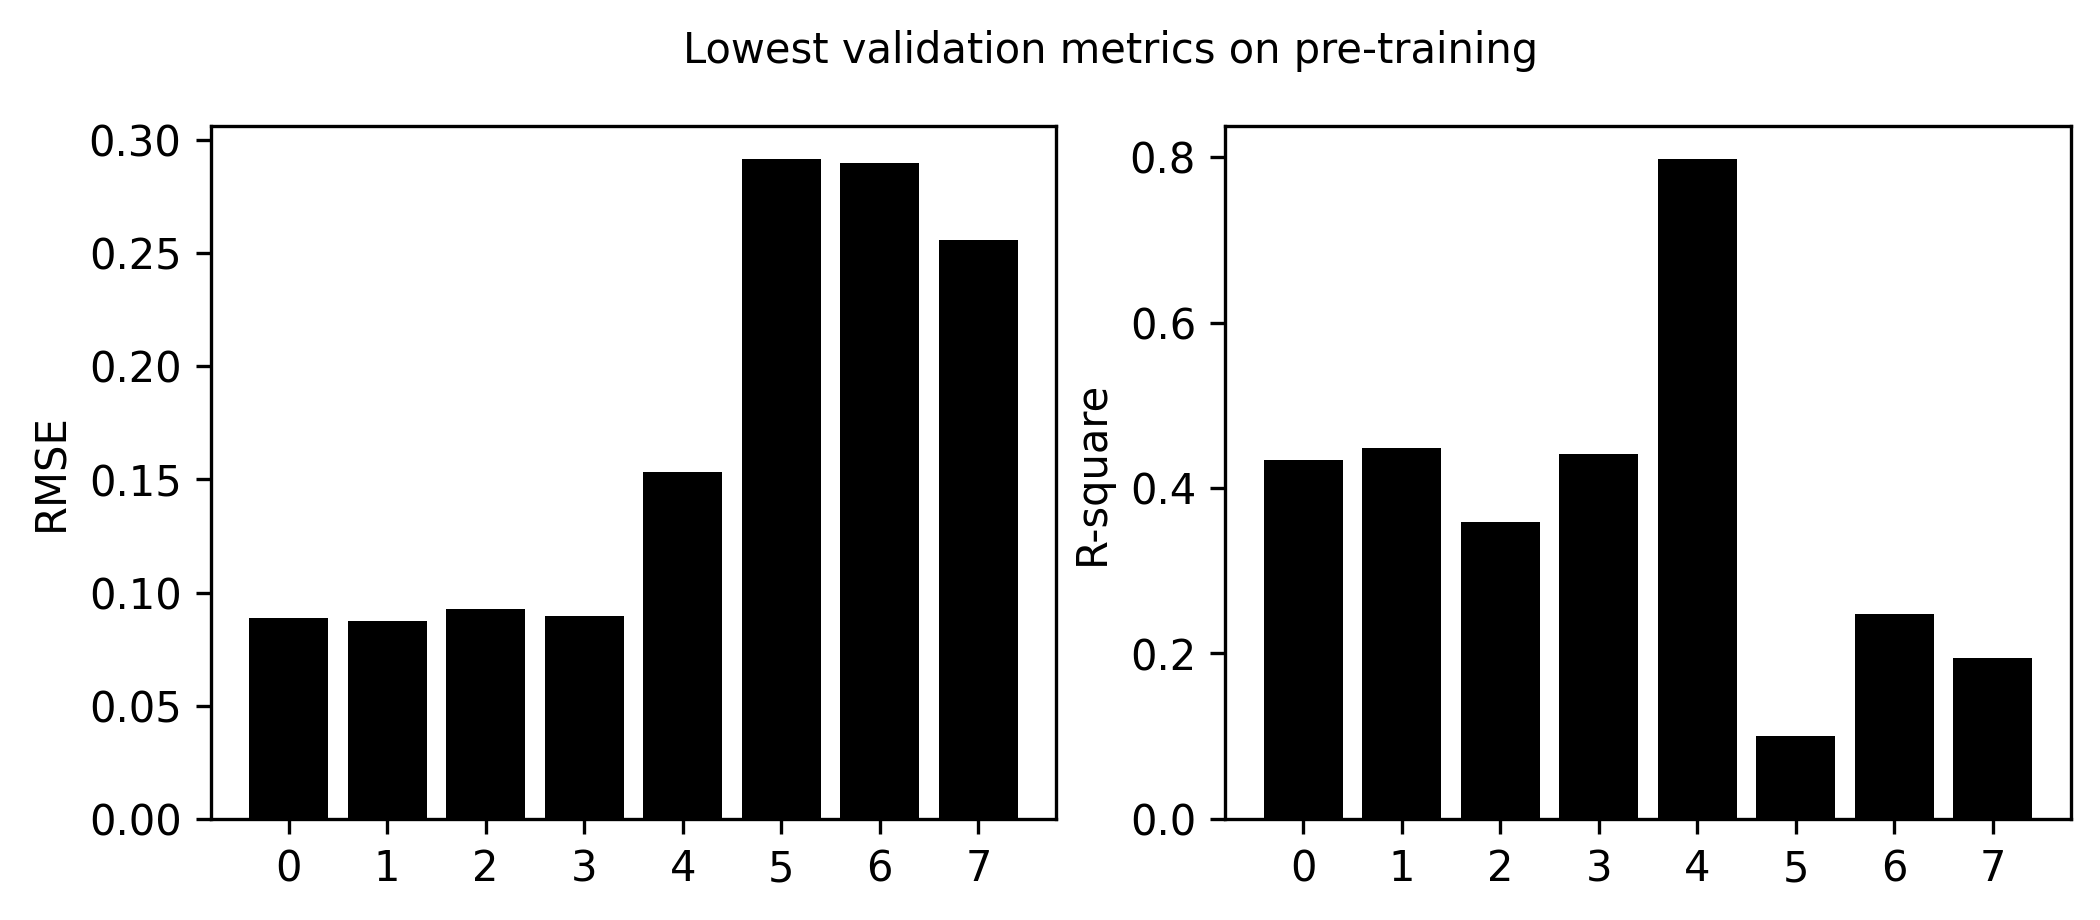

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

axes[0].bar(summary.index, summary['val_rmse'], color='k')
axes[0].set_xticks(summary.index)
axes[0].set_ylabel('RMSE')

axes[1].bar(summary.index, summary['val_r2'], color='k')
axes[1].set_xticks(summary.index)
axes[1].set_ylabel('R-square')

fig.text(0.5, 0.95, 'Lowest validation metrics on pre-training', ha='center', fontsize=10)

plt.show()

## Finetuning

In [8]:
data_loader = build_loader('./data/precords/catalina/fold_0/catalina/', 
                           config, 
                           batch_size=2000, 
                           normalize='zero-mean', 
                           sampling=False,
                           repeat=1,
                           old_version=False)

[INFO] Probed: 0.10 Random: 0.15 Same: 0.15
[INFO] Repeating dataset x1 times
[INFO] Normalization:  zero-mean
[INFO] Loading PT task: Masking
[INFO] Probed: 0.10 Random: 0.15 Same: 0.15
[INFO] Repeating dataset x1 times
[INFO] Normalization:  zero-mean
[INFO] Loading PT task: Masking


In [9]:
config_list = []
for curr_path in paths:            
    model, config = load_pt_model(os.path.join(curr_path, 'pretraining'))
    model.compile(optimizer='adam')
    try:
        loss, r2, rmse = model.evaluate(data_loader['validation'].take(2))
    except:
        loss, rmse, r2, p = model.evaluate(data_loader['validation'].take(2))
        
    config['val_rmse'] = rmse
    config['val_r2'] = r2
    config_list.append(config)

[INFO] Loading BASE
[INFO] Temperature: 0.80
[INFO] Masking Keys tokens only
[INFO] Temperature: 0.80
[INFO] Masking Keys tokens only
[INFO] Temperature: 0.80
[INFO] Masking Keys tokens only
[INFO] Temperature: 0.80
[INFO] Masking Keys tokens only
3/3 [==============================] - 2s 381ms/step - loss: 0.2748 - r_square: -1.3458 - rmse: 0.2748 - p: 0.8576
[INFO] Loading BASE
[INFO] Masking Keys tokens only
[INFO] Masking Keys tokens only
[INFO] Masking Keys tokens only
[INFO] Masking Keys tokens only
3/3 [==============================] - 3s 467ms/step - loss: 0.1722 - r_square: 0.1044 - rmse: 0.1722 - p: 0.5871
[INFO] Loading BASE
[INFO] No mask, just logits
[INFO] No mask, just logits
[INFO] No mask, just logits
[INFO] No mask, just logits
3/3 [==============================] - 3s 467ms/step - loss: 0.2152 - r_square: -0.3089 - rmse: 0.2152 - p: 0.8557
[INFO] Loading BASE
[INFO] Temperature: 0.50
[INFO] Masking Keys tokens only
[INFO] Temperature: 0.50
[INFO] Masking Keys tokens

2024-07-09 20:40:01,809 - WARNING - Inconsistent references when loading the checkpoint into this object graph. For example, in the saved checkpoint object, `model.layer.weight` and `model.layer_copy.weight` reference the same variable, while in the current object these are two different variables. The referenced variables are:(<src.models.astromer_0.Encoder object at 0x7ff56c549a30> and <src.models.astromer_0.RegLayer object at 0x7ff58c43fcd0>).


[INFO] Using PE with c: 2.0
[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens
3/3 [==============================] - 1s 126ms/step - loss: 0.3428 - r_square: -2.3829 - rmse: 0.3428
[INFO] Loading BASE
[INFO] Masking Keys tokens only
[INFO] Masking Keys tokens only
[INFO] Masking Keys tokens only
[INFO] Masking Keys tokens only
3/3 [==============================] - 2s 458ms/step - loss: 0.5542 - r_square: -8.3677 - rmse: 0.5542 - p: 0.9893
[INFO] Loading BASE
[INFO] Masking Keys tokens only
[INFO] Masking Keys tokens only
[INFO] Masking Keys tokens only
[INFO] Masking Keys tokens only
3/3 [==============================] - 3s 457ms/step - loss: 0.7258 - r_square: -14.2996 - rmse: 0.7258 - p: 0.9545
[INFO] Loading BASE
[INFO] Masking Keys tokens only
[INFO] Masking Keys tokens only
[INFO] Masking Keys tokens only
[INFO] Masking Keys tokens only
3/3 [==============================] - 2s 490ms/step - loss: 1.2510 - r_square: -46.7851 - rmse: 1.2510 - p: 0.9801


In [10]:
summary = pd.DataFrame(config_list)
summary = summary[['exp_name', 'lr', 'mask_format', 'temperature', 'probed', 'val_rmse', 'val_r2']]
summary

,exp_name,lr,mask_format,temperature,probed,val_rmse,val_r2
0,maogat,0.00001,K,0.8,0.3,0.854267,-1.359947
1,maogat,0.00001,K,0.0,0.3,0.585625,0.103963
2,maogat,0.00001,logits,0.0,0.3,0.852796,-0.301202
3,maogat,0.00001,K,0.5,0.3,0.789281,-0.106857
4,zero,0.00100,QK,0.0,0.5,0.345242,-2.428786
5,classic,0.00001,K,0.0,0.3,0.993725,-8.454233
6,classic,0.00001,K,0.0,0.5,0.948496,-14.336551
7,classic,0.00001,K,0.0,0.1,0.976732,-46.267929


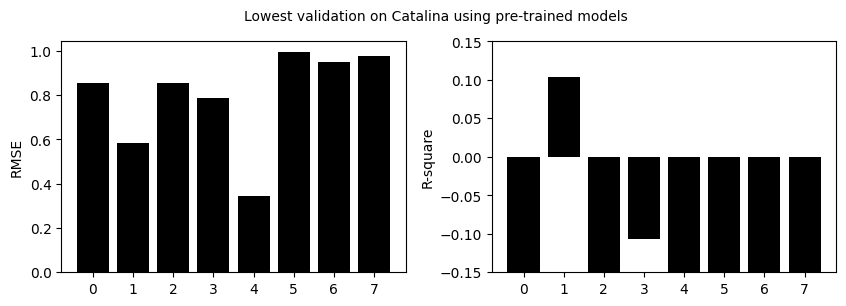

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), gridspec_kw={'wspace':0.25})

axes[0].bar(summary.index, summary['val_rmse'], color='k')
axes[0].set_xticks(summary.index)
axes[0].set_ylabel('RMSE')

axes[1].bar(summary.index, summary['val_r2'], color='k')
axes[1].set_xticks(summary.index)
axes[1].set_ylabel('R-square')
axes[1].set_ylim(-0.15, 0.15)
fig.text(0.5, 0.95, 'Lowest validation on Catalina using pre-trained models', ha='center', fontsize=10)

plt.show()

## Loading downstream data

In [76]:
# model_paths = [
#     './presentation/results/maogat/2024-06-02_04-10-22/',
#     './presentation/results/maogat/2024-06-02_04-18-39/',
#     './presentation/results/maogat/2024-06-02_04-19-29/',
# ]


# model_paths = [
#     './presentation/results/temp/2024-04-13_04-04-34/',
#     './presentation/results/temp/2024-04-18_20-49-50/',
#     './presentation/results/temp/2024-04-24_01-07-33/',
#     './presentation/results/temp/2024-06-24_16-26-17/',
# ]

# model_paths = [
#     './presentation/results/zero/2024-04-24_16-13-23/',
# ]

model_paths = [
    './presentation/results/classic/2024-06-24_17-31-29/',
    './presentation/results/temp/2024-06-24_16-26-17/',
]

model_paths = [
    './presentation/results/maogat/2024-06-02_04-10-22/',
    './presentation/results/paper/macho/',
]

features_spec = ['data']

In [77]:
classification_stats = []
for m in model_paths:
    experiments = glob.glob(os.path.join(m, 'classification', '*', '*', '*','*'))
    for curr in experiments:
        info = get_info_from_path(curr, clf=True)
        with open(os.path.join(curr, 'config.toml'), 'r') as h:
            config = toml.load(h)
            spec = {k:config[k] for k in features_spec}

        with open(os.path.join(curr, 'test_metrics.toml'), 'r') as h:
            metrics = toml.load(h)
            for k in metrics:
                metrics[k] = float(metrics[k])

        combined = {**info, **spec, **metrics, **config}
        classification_stats.append(combined)

In [78]:
clf_stats = pd.DataFrame(classification_stats)

In [79]:
clf_stats_mean = clf_stats.groupby(features_spec+['ds_name', 'spc', 'factors'])['test_f1'].mean()
clf_stats_std = clf_stats.groupby(features_spec+['ds_name', 'spc', 'factors'])['test_f1'].std()
clf_stats_mean = clf_stats_mean.reset_index()
clf_stats_std = clf_stats_std.reset_index()

<Figure size 640x480 with 0 Axes>

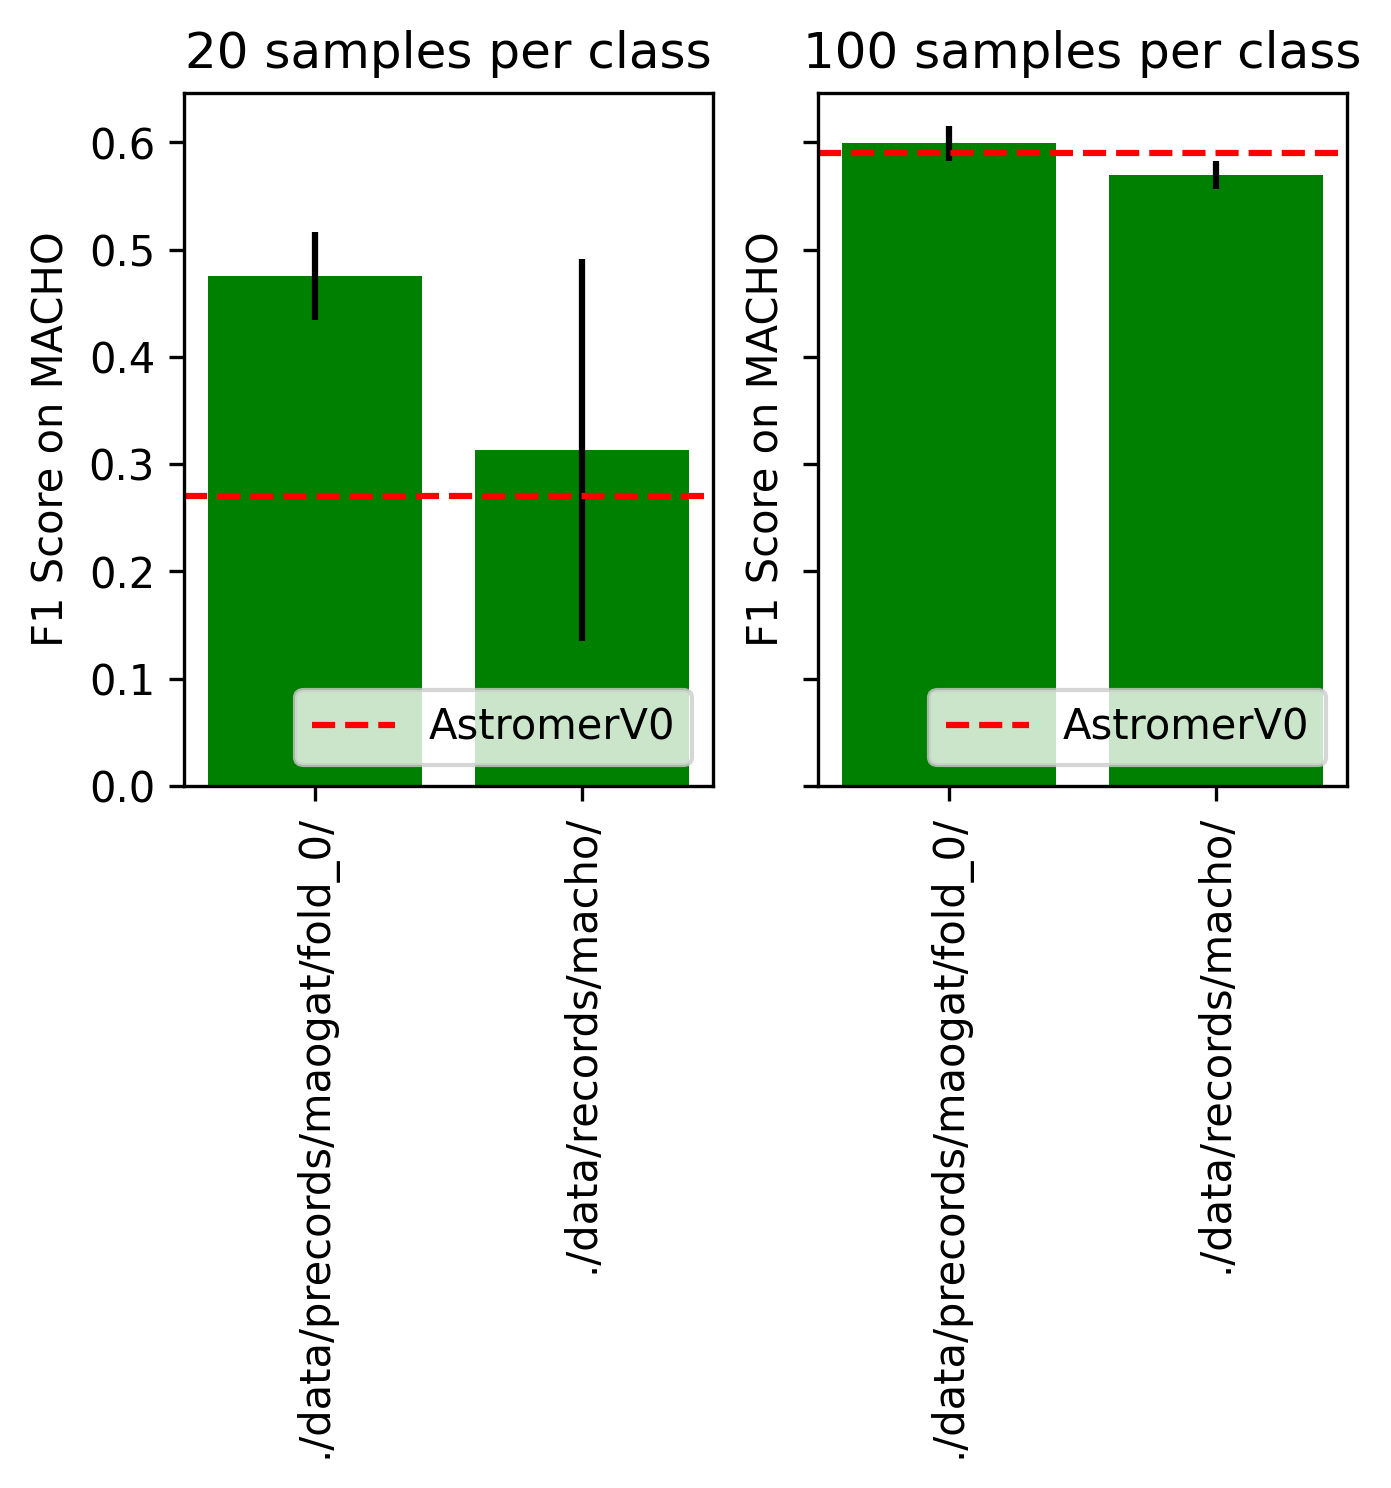

<Figure size 640x480 with 0 Axes>

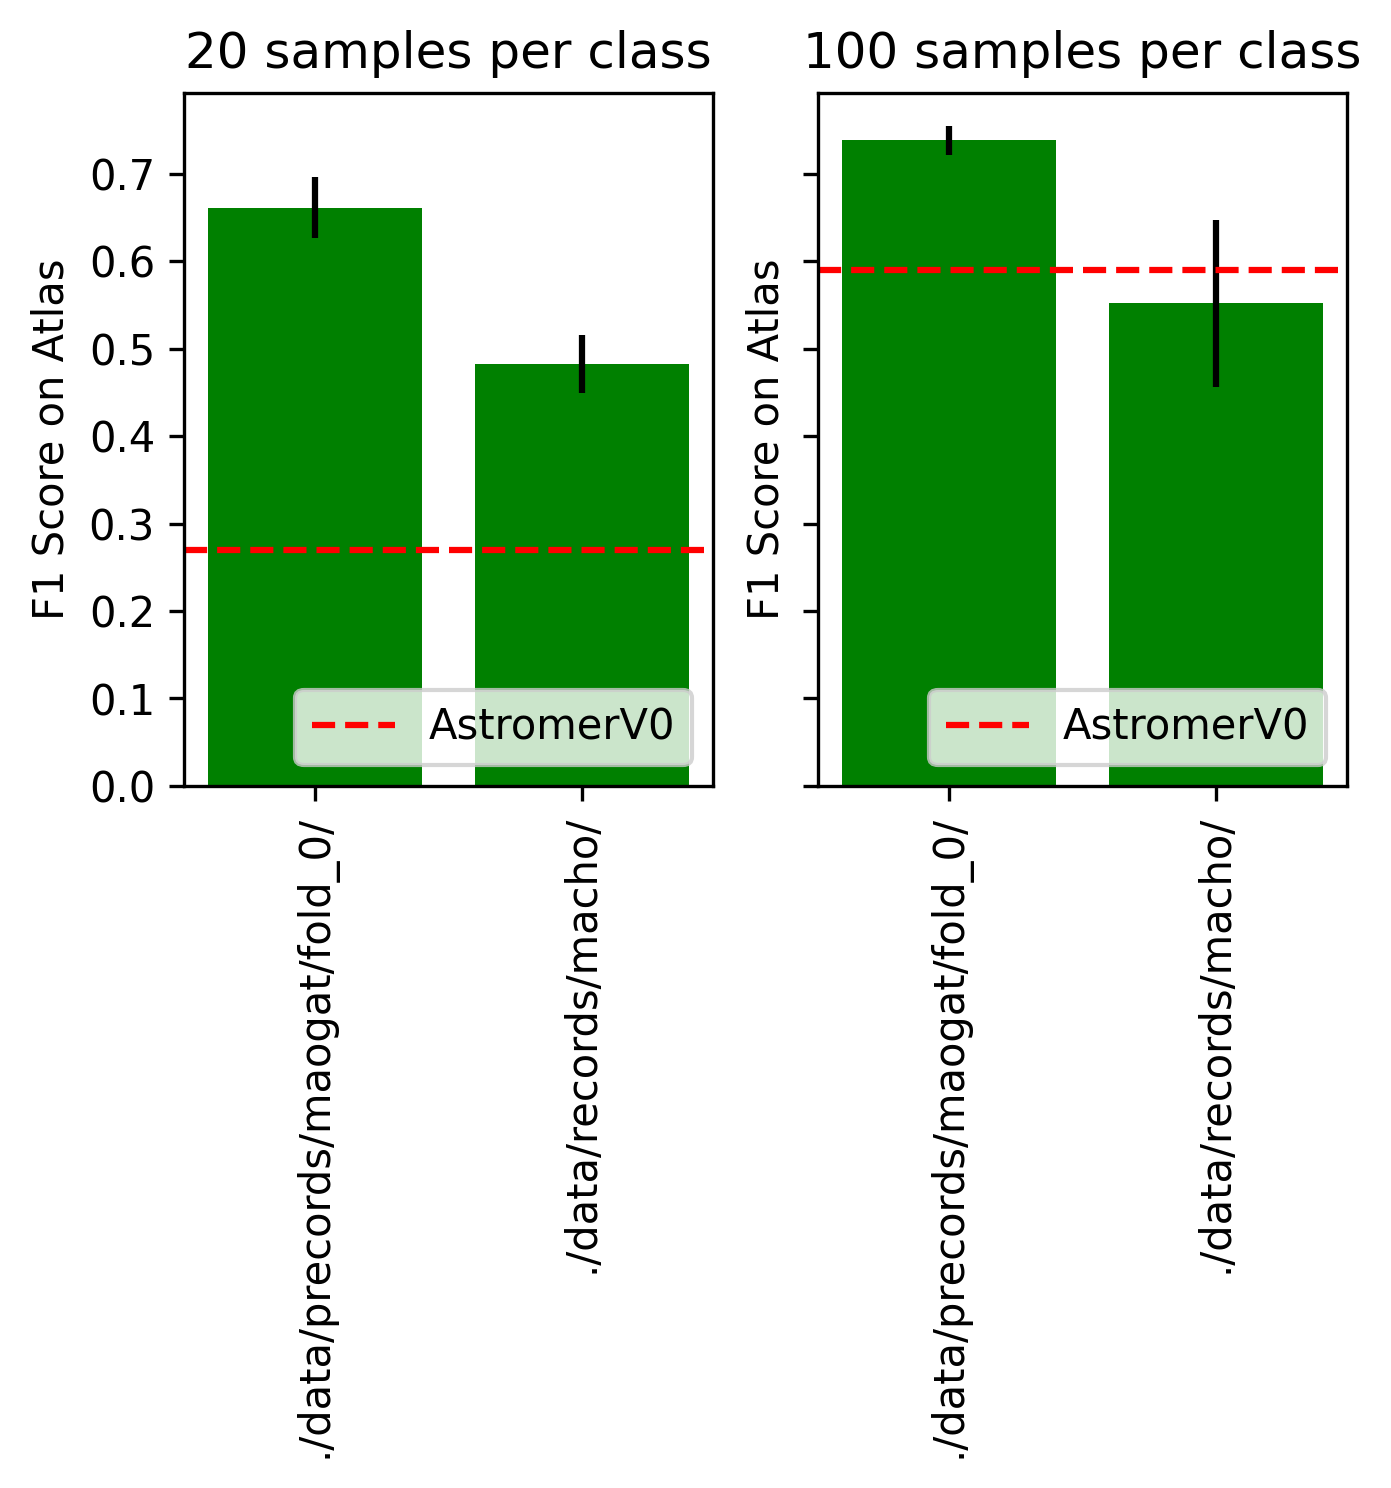

In [80]:
for ds, ds_name in zip(['alcock', 'atlas'], ['MACHO', 'Atlas']):
    plt.clf()
    fig, axes = plt.subplots(1, 2, figsize=(5, 3), 
                             sharey=True, 
                             dpi=300)
    for i, spcc in enumerate([20, 100]):
        sel = clf_stats_mean[(clf_stats_mean['ds_name']==ds) & \
                             (clf_stats_mean['spc']==spcc) & \
                             (clf_stats_mean['factors']== 'avg_mlp')]
        
        sel_std = clf_stats_std[(clf_stats_mean['ds_name']==ds) & \
                             (clf_stats_mean['spc']==spcc) & \
                             (clf_stats_mean['factors']== 'avg_mlp')]
        
        
        sel['label'] = sel.apply(lambda x: get_label(x, features_spec), axis=1)

        axes[i].bar(range(len(sel.index)), sel['test_f1'], color='green', yerr=sel_std['test_f1'])
        axes[i].set_xticks(range(len(sel.index)))
        axes[i].set_xticklabels(sel['label'], rotation=90)
        axes[i].set_title('{} samples per class'.format(spcc))
        axes[i].set_ylabel('F1 Score on {}'.format(ds_name))
        axes[i].axhline(zero_alcock[str(spcc)],color='red', ls='--', label='AstromerV0')
        axes[i].legend(loc='lower right')
    plt.show()